In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
'''
本文件提供了一个基于iTransformer的时间序列预测模型，架构为Encoder-only，损失为均方误差（MSE）。
'''

'\n本文件提供了一个基于iTransformer的时间序列预测模型，架构为Encoder-only，损失为均方误差（MSE）。\n'

In [2]:
# 超参数
num_epochs = 10
learning_rate = 0.01
num_samples = 1000
time_steps = 500
input_len = 64
output_len = 16
input_channels = 8
output_channels = 4
batch_size = 32

In [3]:
class iTransformer(nn.Module):
    def __init__(self, input_len, output_len, input_channels, output_channels, num_layers=6, d_model=64, nhead=8, dim_feedforward=256, drop_out=0.1, batch_first=True):
        super(iTransformer, self).__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        self.input_channels = input_channels
        self.output_channels = output_channels

        self.embedding_layer = nn.Linear(input_len, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=drop_out, batch_first=batch_first)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc1=nn.Linear(d_model, input_len)
        self.fc2=nn.Linear(input_len*input_channels, output_len*output_channels)

    def forward(self, x):
        x=x.permute(0, 2, 1) # (batch_size, input_len, input_channels) -> (batch_size, input_channels, input_len)
        x=self.embedding_layer(x) # (batch_size, input_channels, input_len) -> (batch_size, input_channels, d_model)
        x=self.transformer_encoder(x) # (batch_size, input_channels, d_model) -> (batch_size, input_channels, d_model) # dimension does not change
        x=self.fc1(x) # (batch_size, input_channels, d_model) -> (batch_size, input_channels, input_len)
        x=nn.functional.relu(x)
        x=x.view(-1, self.input_len*self.input_channels) # (batch_size, input_channels, input_len) -> (batch_size, input_len*input_channels)
        x=self.fc2(x) # (batch_size, input_len*input_channels) -> (batch_size, output_len*output_channels)
        x=x.view(-1, self.output_len, self.output_channels) # (batch_size, output_len*output_channels) -> (batch_size, output_len, output_channels)
        return x

    # 评估模型，默认使用MSE
    def evaluate(self, inputs, targets, loss=nn.functional.mse_loss):
        self.eval() # 切换到验证模式
        with torch.no_grad():
            outputs = self.forward(inputs)
            result = loss(outputs, targets).item()
            return result

In [5]:
import mydatasets
import random
# 加载测试数据集
X, Y = mydatasets.load_test_data(id='0',
                                input_dim=(num_samples, input_len, input_channels),
                                output_dim=(num_samples, output_len, output_channels),
                                noise=0.2)

# 自定义数据集类
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X # shape: (num_samples, input_len, input_channels)
        self.Y = Y # shape: (num_samples, output_len, output_channels)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# 构建数据集


indices=list(range(num_samples))
random.shuffle(indices)


train_ratio=0.7 # 训练集占比
val_ratio=0.1 # 验证集占比
test_ratio=0.2 # 测试集占比

num_train=int(train_ratio*num_samples)
num_val=int(val_ratio*num_samples)
num_test=int(test_ratio*num_samples)
assert num_train+num_val+num_test<=num_samples

train_indices=indices[:num_train]
val_indices=indices[num_train:num_train+num_val]
test_indices=indices[num_train+num_val:num_train+num_val+num_test]

train_dataset = TimeSeriesDataset(X[train_indices], Y[train_indices])
val_dataset = TimeSeriesDataset(X[val_indices], Y[val_indices])
test_dataset = TimeSeriesDataset(X[test_indices], Y[test_indices])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 实例化模型、损失函数、评估函数和优化器
model = iTransformer(input_len=input_len, output_len=output_len, input_channels=input_channels, output_channels=output_channels)
loss_func = nn.MSELoss() # MSE，用于拟合
metric_func=nn.L1Loss() # MAE，用于评估
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Train dataset size: X: ({num_train}, {input_len}, {input_channels}); Y: ({num_train}, {output_len}, {output_channels})")
print(f"Val dataset size: X: ({num_val}, {input_len}, {input_channels}), Y: ({num_val}, {output_len}, {output_channels})")
print(f"Test dataset size: X: ({num_test}, {input_len}, {input_channels}), Y: ({num_test}, {output_len}, {output_channels})")


Train dataset size: X: (700, 64, 8); Y: (700, 16, 4)
Val dataset size: X: (100, 64, 8), Y: (100, 16, 4)
Test dataset size: X: (200, 64, 8), Y: (200, 16, 4)


In [6]:
# 训练模型
fit_history=[]
total_time=0 # 总训练时间
for epoch in range(num_epochs):
    t1=time.time() # 该轮开始时间
    train_loss, train_metric = 0.0, 0.0 # 本轮的训练loss和metric
    val_loss, val_metric = 0.0, 0.0 # 本轮的验证loss和metric

    # 训练
    model.train() # 切换到训练模式
    for inputs, targets in train_loader:
        optimizer.zero_grad() # 清空梯度
        outputs = model(inputs) # 前向传播
        loss = loss_func(outputs, targets) # 计算损失
        metric = metric_func(outputs, targets)
        loss.backward() # 反向传播
        optimizer.step() # 更新权重
        train_loss += loss.item()
        train_metric += metric.item()
    
    # 验证
    model.eval()  # 切换到验证模式
    with torch.no_grad():  # 关闭梯度计算
        for inputs, targets in val_loader:
            outputs = model(inputs)  # 前向传播
            loss = loss_func(outputs, targets)  # 计算损失
            metric=metric_func(outputs, targets)
            val_loss += loss.item()
            val_metric += metric.item()

    # 计算各指标的平均值
    average_train_loss=train_loss/len(train_loader) # 本轮的平均训练loss
    average_train_metric=train_metric/len(train_loader) # 本轮的平均训练metric
    average_val_loss=val_loss/len(val_loader) # 本轮的平均验证loss
    average_val_metric=val_metric/len(val_loader) # 本轮的平均验证metric

    # 记录本轮各指标值
    fit_history.append((average_train_loss, average_train_metric, average_val_loss, average_val_metric))

    t2=time.time() # 该轮结束时间
    total_time+=(t2-t1) # 累计训练时间

    # 输出过程信息
    message=f'Epoch [{str(epoch + 1).center(4, " ")}/{num_epochs}], Time: {(t2-t1):.4f}s'
    message+=f', Loss: {average_train_loss:.4f}'
    message+=f', Metric: {average_train_metric:.4f}'
    message+=f', Val Loss: {average_val_loss:.4f}'
    message+=f', Val Metric: {average_val_metric:.4f}'
    print(message)
print(f'Total Time: {total_time:.4f}s')

Epoch [ 1  /10], Time: 0.5804s, Loss: 0.2129, Metric: 0.3081, Val Loss: 0.0457, Val Metric: 0.1701
Epoch [ 2  /10], Time: 0.5806s, Loss: 0.0436, Metric: 0.1666, Val Loss: 0.0425, Val Metric: 0.1637
Epoch [ 3  /10], Time: 0.5982s, Loss: 0.0420, Metric: 0.1636, Val Loss: 0.0416, Val Metric: 0.1633
Epoch [ 4  /10], Time: 0.5974s, Loss: 0.0415, Metric: 0.1626, Val Loss: 0.0417, Val Metric: 0.1627
Epoch [ 5  /10], Time: 0.5797s, Loss: 0.0419, Metric: 0.1636, Val Loss: 0.0428, Val Metric: 0.1641
Epoch [ 6  /10], Time: 0.6004s, Loss: 0.0418, Metric: 0.1631, Val Loss: 0.0441, Val Metric: 0.1680
Epoch [ 7  /10], Time: 0.6113s, Loss: 0.0417, Metric: 0.1631, Val Loss: 0.0416, Val Metric: 0.1625
Epoch [ 8  /10], Time: 0.5939s, Loss: 0.0413, Metric: 0.1623, Val Loss: 0.0412, Val Metric: 0.1623
Epoch [ 9  /10], Time: 0.5746s, Loss: 0.0415, Metric: 0.1627, Val Loss: 0.0412, Val Metric: 0.1619
Epoch [ 10 /10], Time: 0.5829s, Loss: 0.0424, Metric: 0.1644, Val Loss: 0.0425, Val Metric: 0.1639
Total Time

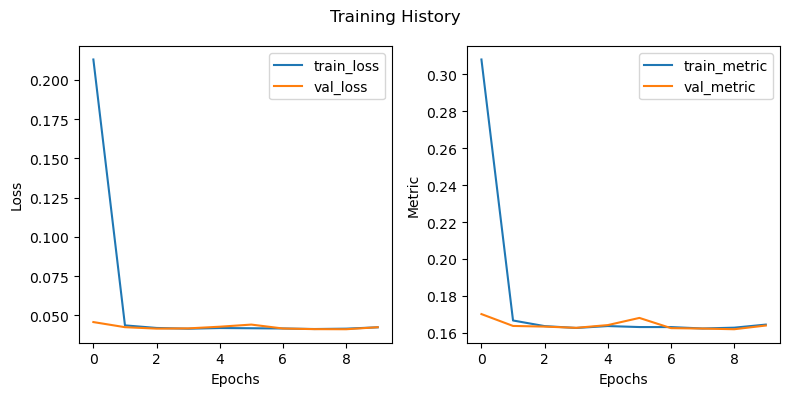

In [7]:
fit_history =np.array(fit_history)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(fit_history[:,0], label='train_loss')
plt.plot(fit_history[:,2], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fit_history[:,1], label='train_metric')
plt.plot(fit_history[:,3], label='val_metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.suptitle("Training History")
plt.legend()

plt.tight_layout() # 调整子图间距，防止重叠
plt.bbox_inches='tight' # 确保保存时图片不丢失边界区域
# plt.savefig('training_history.png', dpi=300) # 保存图片
plt.show()

MSE on sample 266: 0.0451


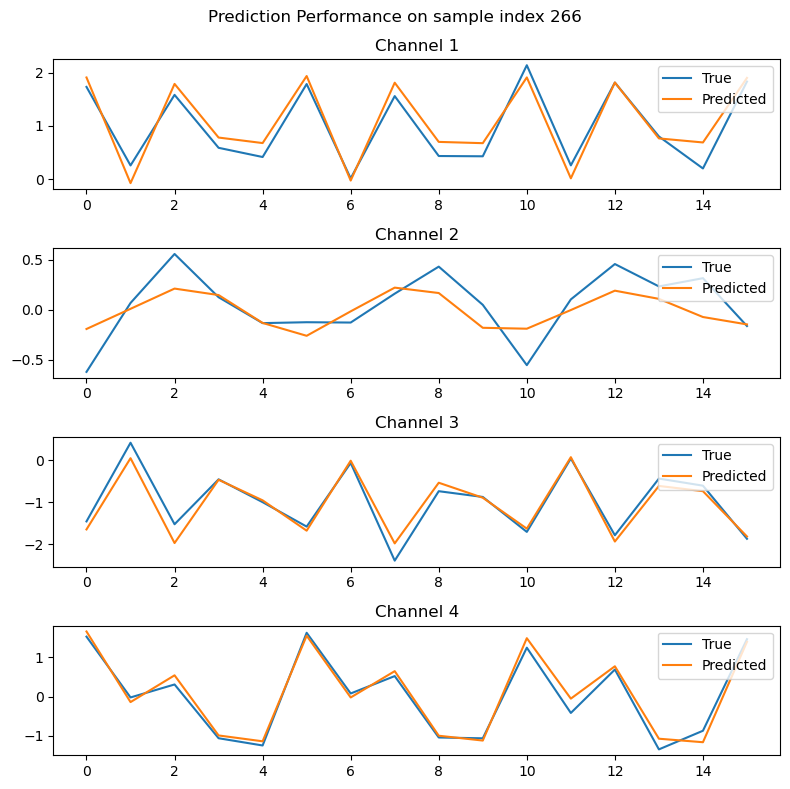

In [8]:
# 可视化预测结果
sample_index=np.random.choice(test_indices, 1)[0]  # 从测试集中随机选择1个样本进行预测
Y_predicted=model(torch.Tensor(X[sample_index]).view(1, input_len, input_channels)).detach().numpy().reshape(output_len, output_channels)
Y_to_predict=Y[sample_index]

mse=np.mean((Y_predicted-Y_to_predict)**2)
print(f"MSE on sample {sample_index}: {mse:.4f}")


# 作图
plt.figure(figsize=(8, 2*output_channels))
plt.suptitle("Prediction Performance on sample index {}".format(sample_index))
for i in range(output_channels):
    plt.subplot(output_channels, 1, i+1)
    plt.title(f"Channel {i+1}")
    plt.plot(Y_to_predict[:,i], label='True')
    plt.plot(Y_predicted[:,i], label='Predicted')
    plt.legend(['True', 'Predicted'], loc='upper right')

plt.tight_layout() # 调整子图间距，防止重叠
plt.bbox_inches='tight' # 确保保存时图片不丢失边界区域
# plt.savefig('performance.png', dpi=300) # 保存图片
plt.show()


In [9]:
# 在整个测试集上评估模型
print("MSE loss on test set:" ,model.evaluate(torch.Tensor(X[test_indices]).float(), torch.Tensor(Y[test_indices]).float()))

MSE loss on test set: 0.04277922958135605
